AIN311 CLASS PROJECT

MELİKE NUR DULKADİR & SARE NAZ ERSOY

# Career Path Predictor

Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import tree,svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
sns.set(style="white")
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/sayalideo/Job-Role-Prediction-/master/Data/roo_data.csv')
df.head()

Acedamic percentage in Operating Systems  percentage in Algorithms  \
0                                        69                        63   
1                                        78                        62   
2                                        71                        86   
3                                        76                        87   
4                                        92                        62   

   Percentage in Programming Concepts  Percentage in Software Engineering  \
0                                  78                                  87   
1                                  73                                  60   
2                                  91                                  87   
3                                  60                                  84   
4                                  90                                  67   

   Percentage in Computer Networks  Percentage in Electronics Subjects  \
0                               94                                  94   
1                               71                                  70   
2                               61                                  81   
3                               89                                  73   
4                               71                                  89   

   Percentage in Computer Architecture  Percentage in Mathematics  \
0                                   87                         84   
1                                   73                         84   
2                                   72                         72   
3                                   62                         88   
4                                   73                         71   

   Percentage in Communication skills  Hours working per day  ...  \
0                                  61                      9  ...   
1                                  91                     12  ...   
2                                  94                     11  ...   
3                                  69                      7  ...   
4                                  73                      4  ...   

   Interested Type of Books  Salary Range Expected  In a Realtionship?  \
0              Prayer books                 salary                  no   
1                 Childrens                 salary                 yes   
2                    Travel                   Work                  no   
3                   Romance                   Work                 yes   
4                 Cookbooks                 salary                  no   

   Gentle or Tuff behaviour? Management or Technical Salary/work  \
0                   stubborn              Management      salary   
1                     gentle               Technical      salary   
2                   stubborn              Management        work   
3                     gentle              Management        work   
4                   stubborn              Management        work   

  hard/smart worker worked in teams ever? Introvert  \
0       hard worker                   yes        no   
1       hard worker                    no       yes   
2       hard worker                    no       yes   
3      smart worker                   yes       yes   
4       hard worker                   yes       yes   

              Suggested Job Role  
0         Database Administrator  
1                Project Manager  
2                Project Manager  
3         Security Administrator  
4  Business Intelligence Analyst  

[5 rows x 39 columns]

Some utils functions for understand the data clearly

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### Properties #####################")
    print(df.describe())

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    #num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th anddataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    #cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    #num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
   # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [5]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [6]:
def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [7]:
def check_outlier(dataframe, col_name, q1=.25, q3=.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [8]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [9]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [10]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

In [11]:
def plot_importance(model, features, save=False):

    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(20, 20))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:len(features)])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

In [12]:
check_df(df)

##################### Shape #####################
(20000, 39)
##################### Types #####################
Acedamic percentage in Operating Systems     int64
percentage in Algorithms                     int64
Percentage in Programming Concepts           int64
Percentage in Software Engineering           int64
Percentage in Computer Networks              int64
Percentage in Electronics Subjects           int64
Percentage in Computer Architecture          int64
Percentage in Mathematics                    int64
Percentage in Communication skills           int64
Hours working per day                        int64
Logical quotient rating                      int64
hackathons                                   int64
coding skills rating                         int64
public speaking points                       int64
can work long time before system?           object
self-learning capability?                   object
Extra-courses did                           object
certifications       

In [13]:
df.columns = ['Academic_Percentage_In_Operating_Systems', 'Algorithms_Percentage',
              'Programming_Concepts_Percentage',
              'Software_Engineering_Percentage', 'Computer_Networks_Percentage',
              'Electronics_Subjects_Percentage',
              'Computer_Architecture_Percentage', 'Mathematics_Percentage',
              'Communication_Skills_Percentage', 'Hours_Working_Per_Day',
              'Logical_Quotient_Rating', 'Hackathons', 'Coding_Skills_Rating',
              'Public_Speaking_Points', 'Can_Work_Long_Time_Before_System',
              'Self-Learning_Capability', 'Extra_Courses_Did', 'Certifications',
              'Workshops', 'Talent_Tests_Taken', 'Olympiads',
              'Reading_And_Writing_Skills', 'Memory_Capability_Score',
              'Interested_Subjects', 'Interested_Career_Area', 'Job/Higher_Studies',
              'Type_Of_Company_Want_To_Settle_In',
              'Taken_Inputs_From_Seniors_Or_Elders', 'Interested_In_Games',
              'Interested_Type_Of_Books', 'Salary_Range_Expected',
              'Being_In_A_Relationship', 'Gentle_Or_Tuff_Behaviour',
              'Management_Or_Technical', 'Salary/Work', 'Worker_Type',
              'Worked_In_Teams_Ever', 'Introvert', 'Suggested_Job_Role']

In [14]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 20000
Variables: 39
cat_cols: 24
num_cols: 14
cat_but_car: 1


In [15]:
num_cols

['Academic_Percentage_In_Operating_Systems',
 'Algorithms_Percentage',
 'Programming_Concepts_Percentage',
 'Software_Engineering_Percentage',
 'Computer_Networks_Percentage',
 'Electronics_Subjects_Percentage',
 'Computer_Architecture_Percentage',
 'Mathematics_Percentage',
 'Communication_Skills_Percentage',
 'Hours_Working_Per_Day',
 'Logical_Quotient_Rating',
 'Hackathons',
 'Coding_Skills_Rating',
 'Public_Speaking_Points']

In [16]:
for col in num_cols:
    print(check_outlier(df,col))

False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [17]:
scaler = StandardScaler()
cols_to_scale = num_cols

#create and fit scaler
scaler.fit(df[cols_to_scale])

#scale selected data
df[cols_to_scale] = scaler.transform(df[cols_to_scale])


<AxesSubplot:>

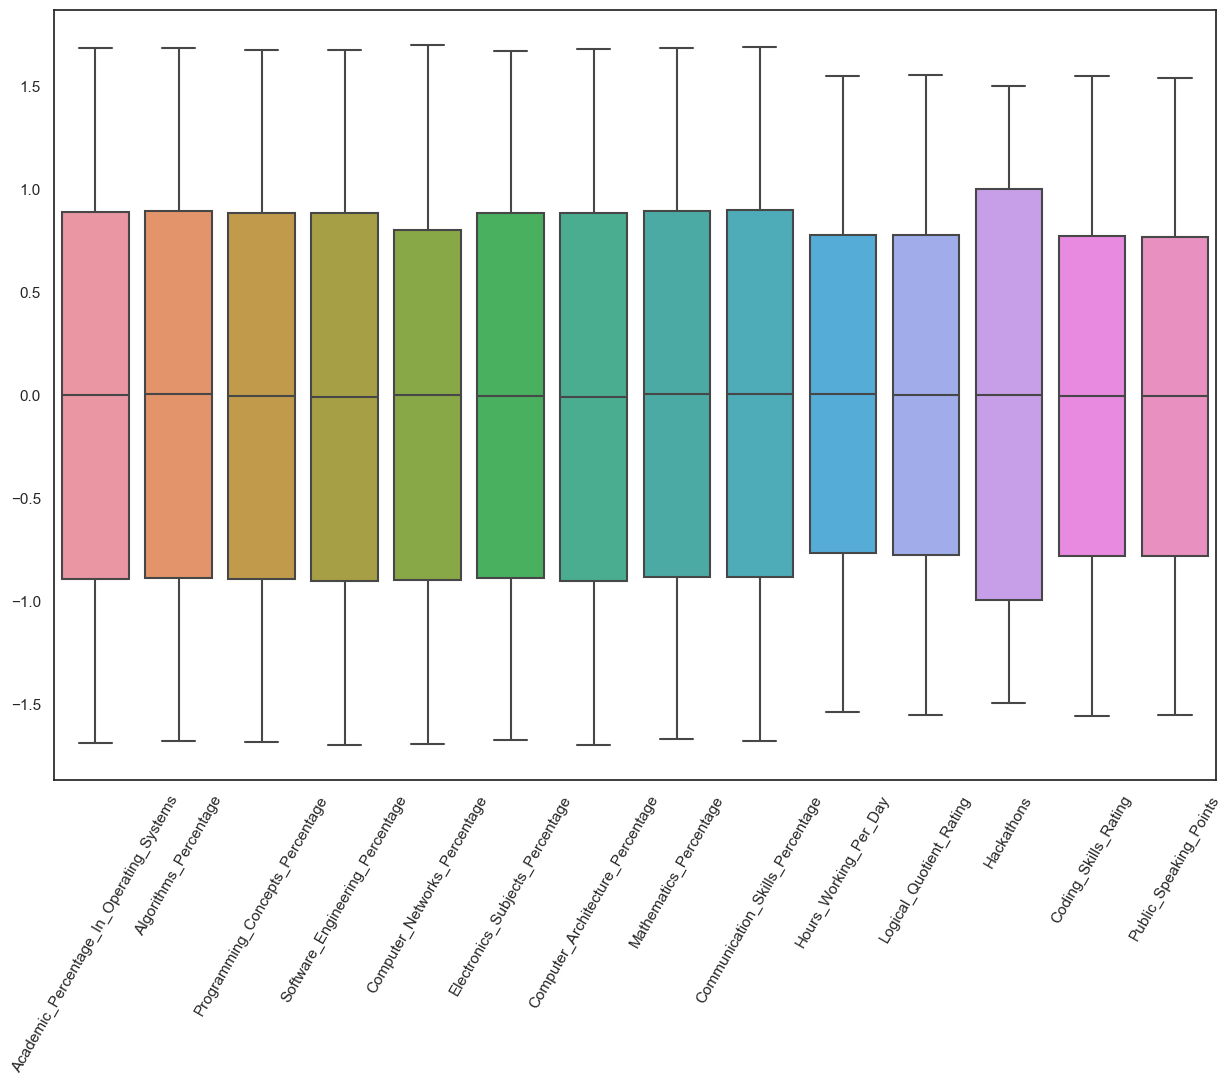

In [18]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
sns.boxplot(data=df[num_cols], ax=ax)

In [19]:
print("\n######## List of Categorical features ########\n")
for index,col in enumerate(cat_cols):
    print(index,col)


######## List of Categorical features ########

0 Can_Work_Long_Time_Before_System
1 Self-Learning_Capability
2 Extra_Courses_Did
3 Certifications
4 Workshops
5 Talent_Tests_Taken
6 Olympiads
7 Reading_And_Writing_Skills
8 Memory_Capability_Score
9 Interested_Subjects
10 Interested_Career_Area
11 Job/Higher_Studies
12 Type_Of_Company_Want_To_Settle_In
13 Taken_Inputs_From_Seniors_Or_Elders
14 Interested_In_Games
15 Salary_Range_Expected
16 Being_In_A_Relationship
17 Gentle_Or_Tuff_Behaviour
18 Management_Or_Technical
19 Salary/Work
20 Worker_Type
21 Worked_In_Teams_Ever
22 Introvert
23 Suggested_Job_Role


In [20]:
for i in cat_cols:
    print(df[i].value_counts(), end="\n\n")

yes    10020
no      9980
Name: Can_Work_Long_Time_Before_System, dtype: int64

yes    10102
no      9898
Name: Self-Learning_Capability, dtype: int64

no     10049
yes     9951
Name: Extra_Courses_Did, dtype: int64

r programming           2275
machine learning        2255
shell programming       2252
information security    2250
full stack              2239
hadoop                  2210
python                  2198
app development         2165
distro making           2156
Name: Certifications, dtype: int64

web technologies     2586
data science         2551
game development     2522
database security    2517
system designing     2516
hacking              2473
testing              2444
cloud computing      2391
Name: Workshops, dtype: int64

yes    10047
no      9953
Name: Talent_Tests_Taken, dtype: int64

yes    10079
no      9921
Name: Olympiads, dtype: int64

excellent    6696
poor         6683
medium       6621
Name: Reading_And_Writing_Skills, dtype: int64

poor         6677
exce

In [21]:
dummy_cols = ['Interested_Subjects',
              'Interested_Career_Area',
              'Type_Of_Company_Want_To_Settle_In',
              'Worker_Type','Certifications',
              'Workshops']
dummy_cols

['Interested_Subjects',
 'Interested_Career_Area',
 'Type_Of_Company_Want_To_Settle_In',
 'Worker_Type',
 'Certifications',
 'Workshops']

In [22]:
df.head()

Academic_Percentage_In_Operating_Systems  Algorithms_Percentage  \
0                                 -0.793450              -1.380807   
1                                  0.098925              -1.479803   
2                                 -0.595145               0.896086   
3                                 -0.099381               0.995082   
4                                  1.487064              -1.479803   

   Programming_Concepts_Percentage  Software_Engineering_Percentage  \
0                         0.096941                         0.981950   
1                        -0.396421                        -1.694608   
2                         1.379680                         0.981950   
3                        -1.679160                         0.684554   
4                         1.281008                        -1.000686   

   Computer_Networks_Percentage  Electronics_Subjects_Percentage  \
0                      1.700806                         1.670279   
1                     -0.594640                        -0.689921   
2                     -1.592660                         0.391837   
3                      1.201796                        -0.394896   
4                     -0.594640                         1.178570   

   Computer_Architecture_Percentage  Mathematics_Percentage  \
0                          0.986229                0.699022   
1                         -0.404204                0.699022   
2                         -0.503520               -0.484608   
3                         -1.496687                1.093566   
4                         -0.404204               -0.583244   

   Communication_Skills_Percentage  Hours_Working_Per_Day  ...  \
0                        -1.575875               0.390962  ...   
1                         1.393469               1.547595  ...   
2                         1.690403               1.162051  ...   
3                        -0.784050              -0.380128  ...   
4                        -0.388138              -1.536762  ...   

   Interested_Type_Of_Books  Salary_Range_Expected  Being_In_A_Relationship  \
0              Prayer books                 salary                       no   
1                 Childrens                 salary                      yes   
2                    Travel                   Work                       no   
3                   Romance                   Work                      yes   
4                 Cookbooks                 salary                       no   

   Gentle_Or_Tuff_Behaviour Management_Or_Technical Salary/Work   Worker_Type  \
0                  stubborn              Management      salary   hard worker   
1                    gentle               Technical      salary   hard worker   
2                  stubborn              Management        work   hard worker   
3                    gentle              Management        work  smart worker   
4                  stubborn              Management        work   hard worker   

  Worked_In_Teams_Ever Introvert             Suggested_Job_Role  
0                  yes        no         Database Administrator  
1                   no       yes                Project Manager  
2                   no       yes                Project Manager  
3                  yes       yes         Security Administrator  
4                  yes       yes  Business Intelligence Analyst  

[5 rows x 39 columns]

In [23]:
cat_cols.remove("Suggested_Job_Role")
label_encoder = LabelEncoder()
for cat_col in cat_cols:
    if cat_col not in dummy_cols:
        df[cat_col]= label_encoder.fit_transform(df[cat_col])

In [24]:
df2 = df[dummy_cols]

In [25]:
df2 = pd.get_dummies(df2,prefix="dum",drop_first=True)

In [26]:
df = df.join(df2)

In [27]:
df.drop(columns=dummy_cols, inplace=True)

In [28]:
df.head()

Academic_Percentage_In_Operating_Systems  Algorithms_Percentage  \
0                                 -0.793450              -1.380807   
1                                  0.098925              -1.479803   
2                                 -0.595145               0.896086   
3                                 -0.099381               0.995082   
4                                  1.487064              -1.479803   

   Programming_Concepts_Percentage  Software_Engineering_Percentage  \
0                         0.096941                         0.981950   
1                        -0.396421                        -1.694608   
2                         1.379680                         0.981950   
3                        -1.679160                         0.684554   
4                         1.281008                        -1.000686   

   Computer_Networks_Percentage  Electronics_Subjects_Percentage  \
0                      1.700806                         1.670279   
1                     -0.594640                        -0.689921   
2                     -1.592660                         0.391837   
3                      1.201796                        -0.394896   
4                     -0.594640                         1.178570   

   Computer_Architecture_Percentage  Mathematics_Percentage  \
0                          0.986229                0.699022   
1                         -0.404204                0.699022   
2                         -0.503520               -0.484608   
3                         -1.496687                1.093566   
4                         -0.404204               -0.583244   

   Communication_Skills_Percentage  Hours_Working_Per_Day  ...  dum_python  \
0                        -1.575875               0.390962  ...           0   
1                         1.393469               1.547595  ...           0   
2                         1.690403               1.162051  ...           0   
3                        -0.784050              -0.380128  ...           1   
4                        -0.388138              -1.536762  ...           0   

   dum_r programming  dum_shell programming  dum_data science  \
0                  0                      1                 0   
1                  0                      0                 0   
2                  0                      0                 0   
3                  0                      0                 1   
4                  0                      0                 0   

   dum_database security  dum_game development  dum_hacking  \
0                      0                     0            0   
1                      1                     0            0   
2                      0                     0            0   
3                      0                     0            0   
4                      0                     0            0   

   dum_system designing  dum_testing  dum_web technologies  
0                     0            0                     0  
1                     0            0                     0  
2                     0            0                     1  
3                     0            0                     0  
4                     0            0                     0  

[5 rows x 72 columns]

<AxesSubplot:>

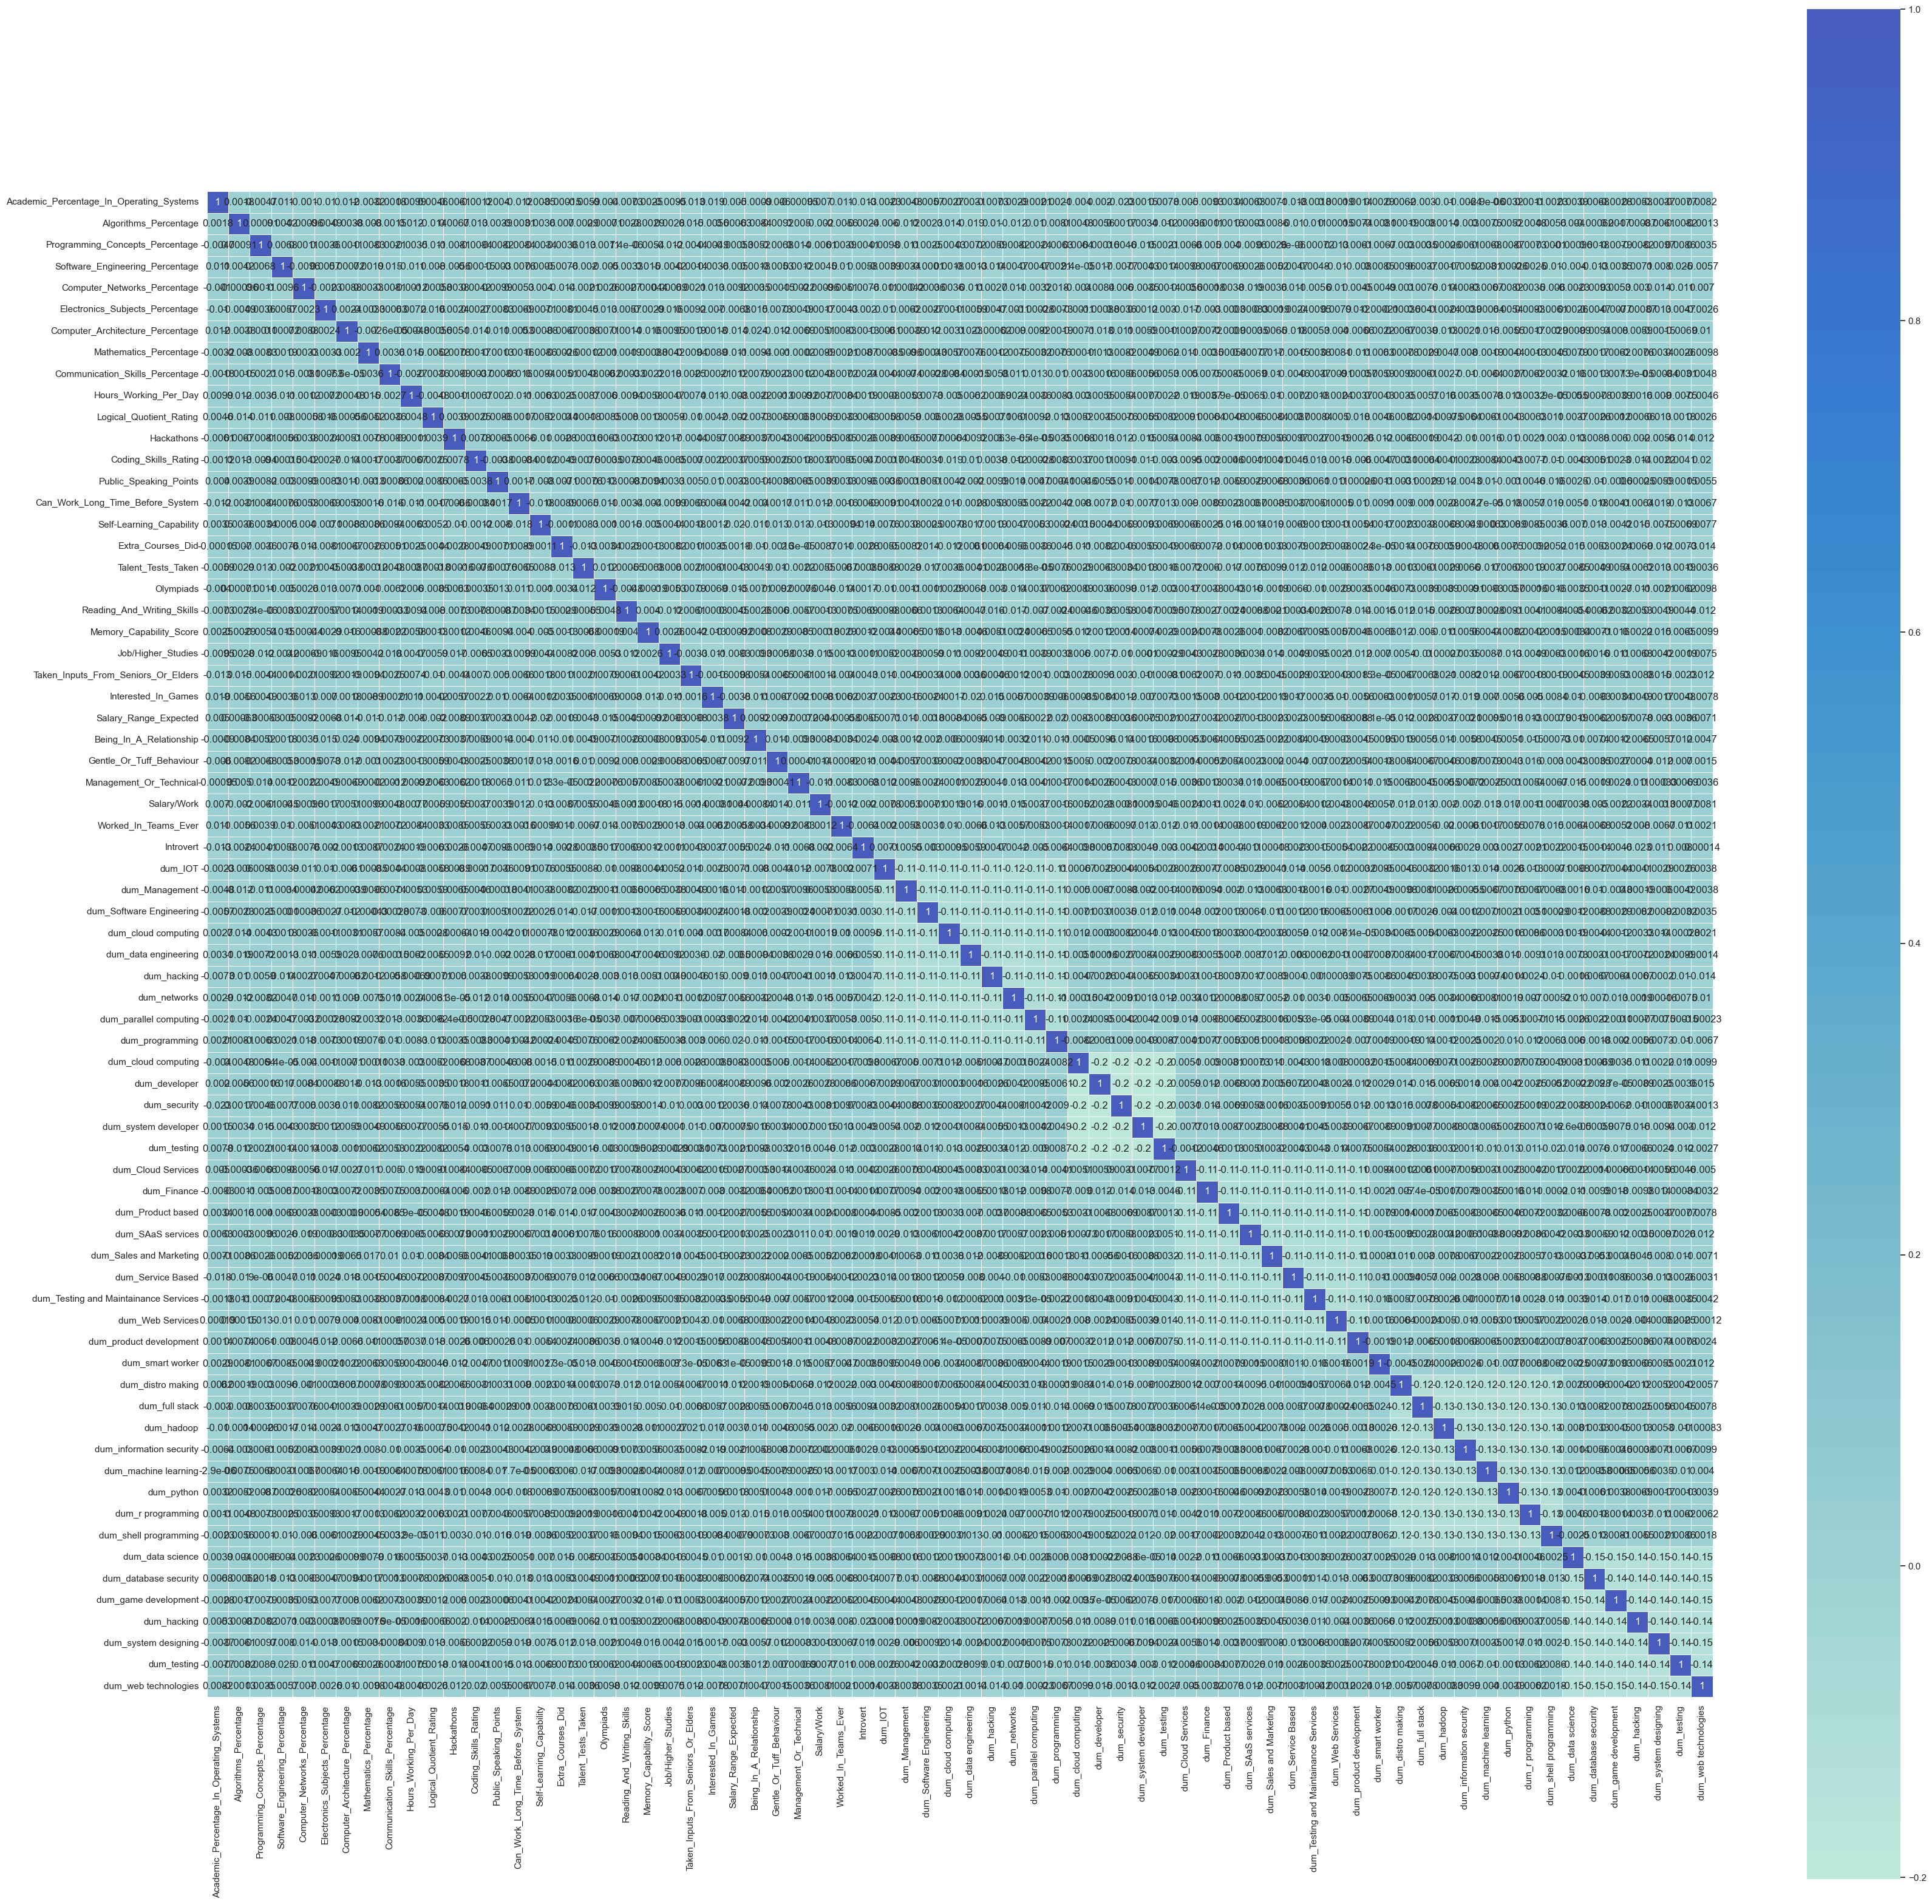

In [29]:
df3 = df.drop(columns = ["Suggested_Job_Role"])
df3 = df3.corr()
f,axes = plt.subplots(1,1,figsize = (40,40))
sns.heatmap(df3,square=True,annot = True,linewidth = .4,center = 2,ax = axes)

In [30]:
pca = PCA()
pca.fit(df3)
PC_components = np.arange(pca.n_components_) + 1

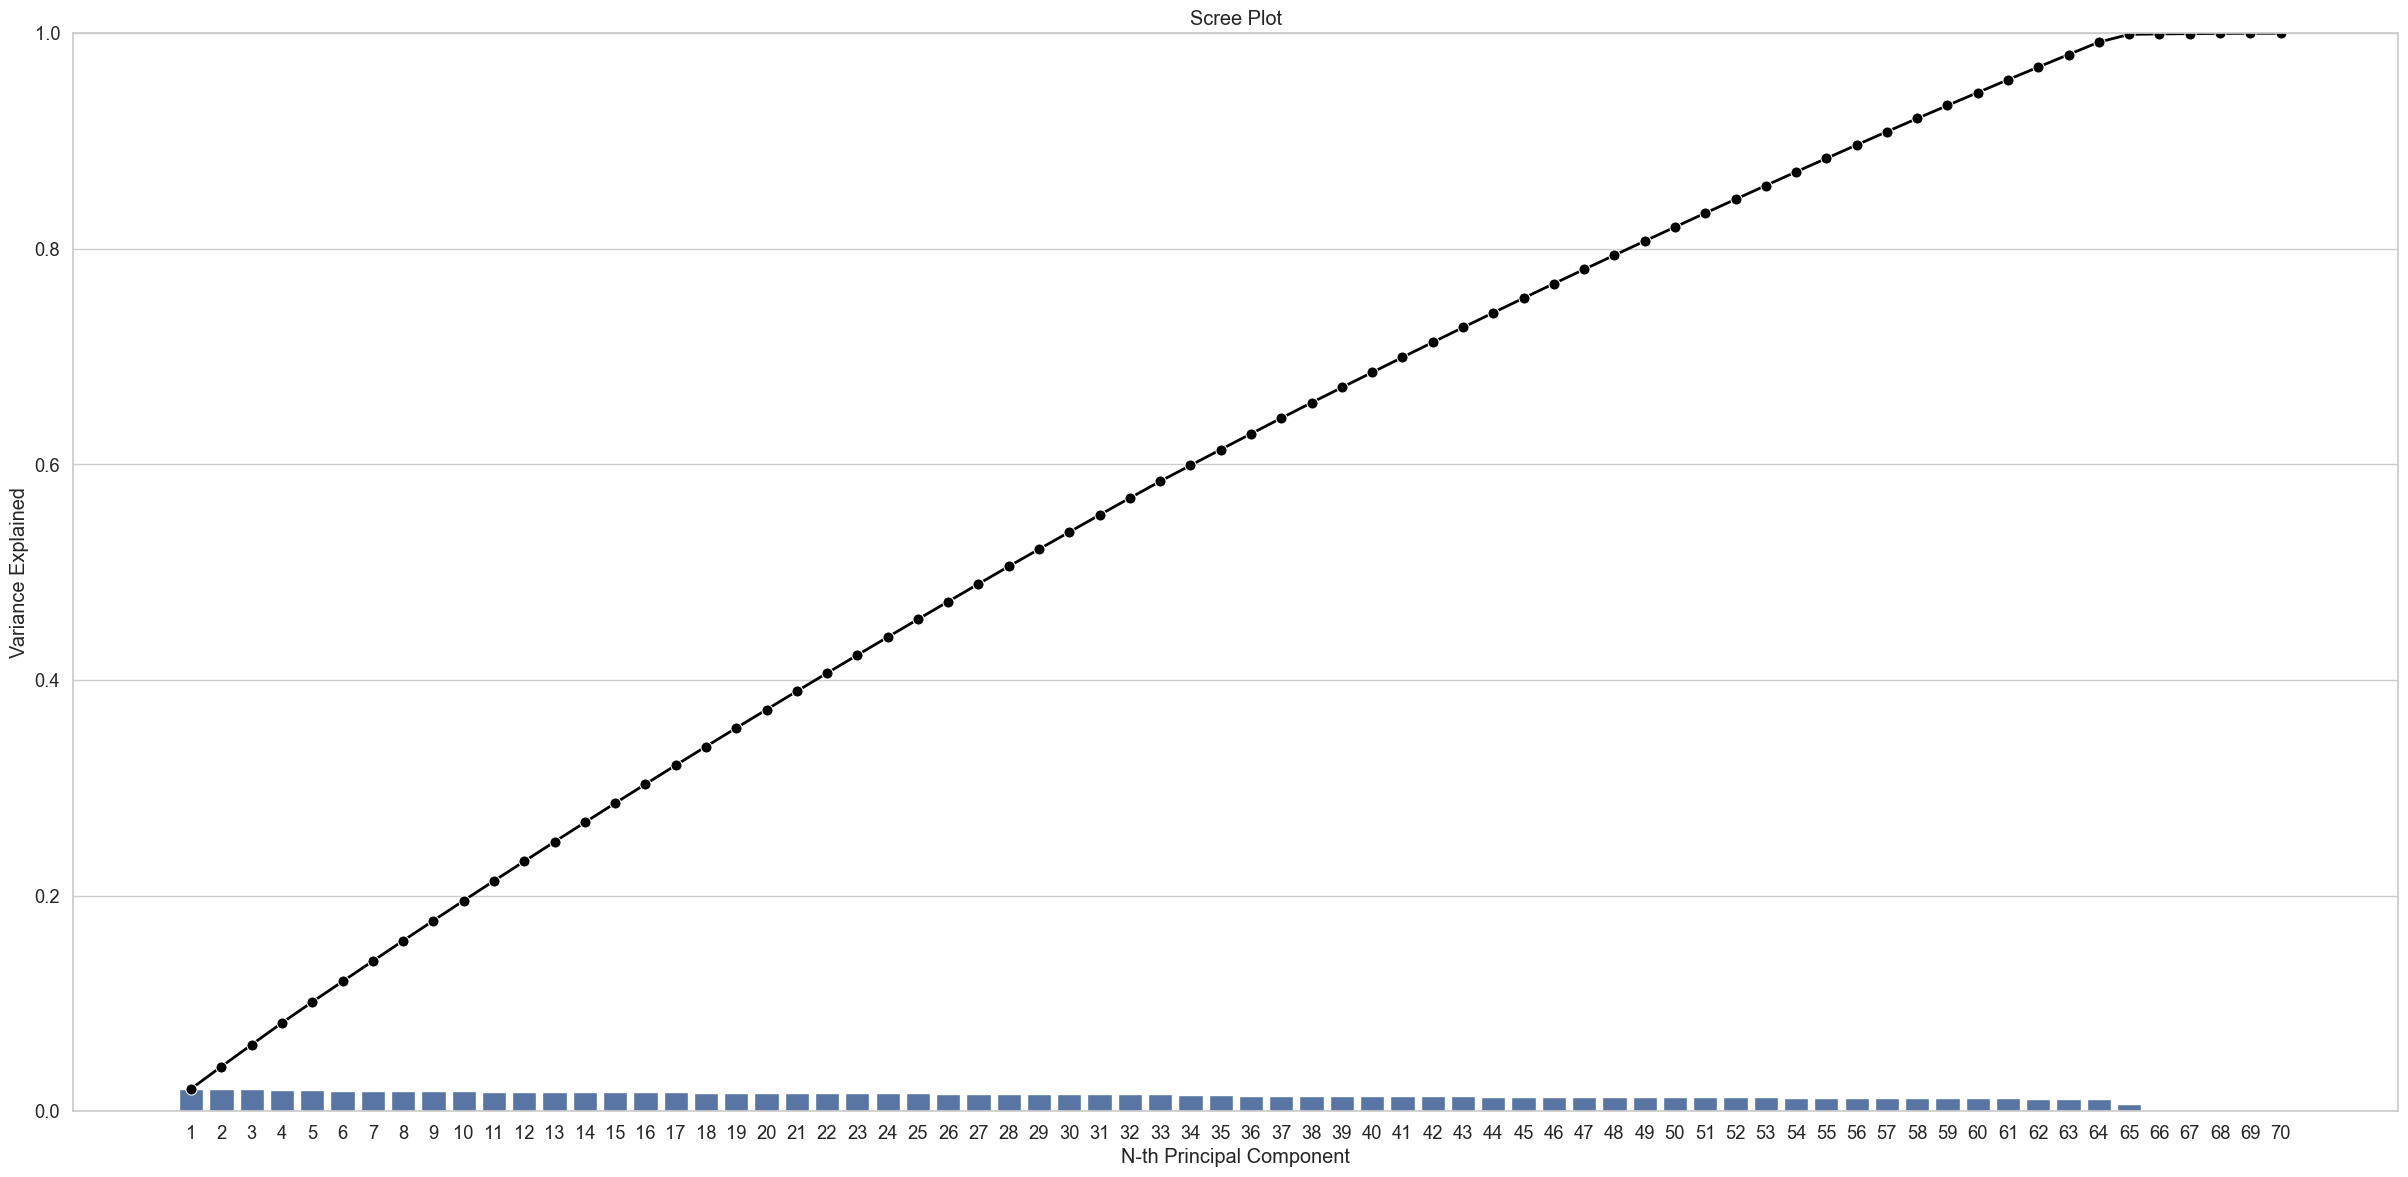

In [31]:
# Scree Plot
scree_plot = sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(30, 14))
scree_plot = sns.barplot(x=PC_components, y=pca.explained_variance_ratio_, color='b')
scree_plot = sns.lineplot(x=PC_components-1, y=np.cumsum(pca.explained_variance_ratio_), color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.show()
#As you see after 18 feature relation, there is no change in data explainability.
#Which means we can use 18 feature to explain our data.

As you see, with specific 7 columns,we obtained nothing. So, we decided to find and drop them.

In [32]:
drop_list = high_correlated_cols(df)

In [33]:
df.drop(columns=drop_list, axis = 1, inplace=True)

We thought that the interested type of book is unnecessary and decided to drop that as well.

In [34]:
df.drop(columns=['Interested_Type_Of_Books'], axis=1,inplace=True)

In [35]:
df.corr()

Academic_Percentage_In_Operating_Systems  \
Academic_Percentage_In_Operating_Systems                                  1.000000   
Algorithms_Percentage                                                     0.001781   
Programming_Concepts_Percentage                                          -0.004693   
Software_Engineering_Percentage                                           0.010691   
Computer_Networks_Percentage                                             -0.001003   
...                                                                            ...   
dum_data science                                                          0.003940   
dum_database security                                                     0.006849   
dum_game development                                                     -0.002835   
dum_system designing                                                     -0.003674   
dum_web technologies                                                      0.008172   

                                          Algorithms_Percentage  \
Academic_Percentage_In_Operating_Systems               0.001781   
Algorithms_Percentage                                  1.000000   
Programming_Concepts_Percentage                        0.000914   
Software_Engineering_Percentage                        0.004178   
Computer_Networks_Percentage                          -0.000961   
...                                                         ...   
dum_data science                                       0.003964   
dum_database security                                 -0.000621   
dum_game development                                   0.001724   
dum_system designing                                  -0.006055   
dum_web technologies                                  -0.001255   

                                          Programming_Concepts_Percentage  \
Academic_Percentage_In_Operating_Systems                        -0.004693   
Algorithms_Percentage                                            0.000914   
Programming_Concepts_Percentage                                  1.000000   
Software_Engineering_Percentage                                  0.006810   
Computer_Networks_Percentage                                     0.001120   
...                                                                   ...   
dum_data science                                                -0.000958   
dum_database security                                            0.001812   
dum_game development                                            -0.007896   
dum_system designing                                            -0.009732   
dum_web technologies                                             0.003464   

                                          Software_Engineering_Percentage  \
Academic_Percentage_In_Operating_Systems                         0.010691   
Algorithms_Percentage                                            0.004178   
Programming_Concepts_Percentage                                  0.006810   
Software_Engineering_Percentage                                  1.000000   
Computer_Networks_Percentage                                    -0.009601   
...                                                                   ...   
dum_data science                                                -0.003953   
dum_database security                                           -0.013119   
dum_game development                                            -0.003544   
dum_system designing                                             0.007985   
dum_web technologies                                            -0.005693   

                                          Computer_Networks_Percentage  \
Academic_Percentage_In_Operating_Systems                     -0.001003   
Algorithms_Percentage                                        -0.000961   
Programming_Concepts_Percentage                               0.001120   
Software_Engineering_Percentage                           

<AxesSubplot:xlabel='Suggested_Job_Role', ylabel='count'>

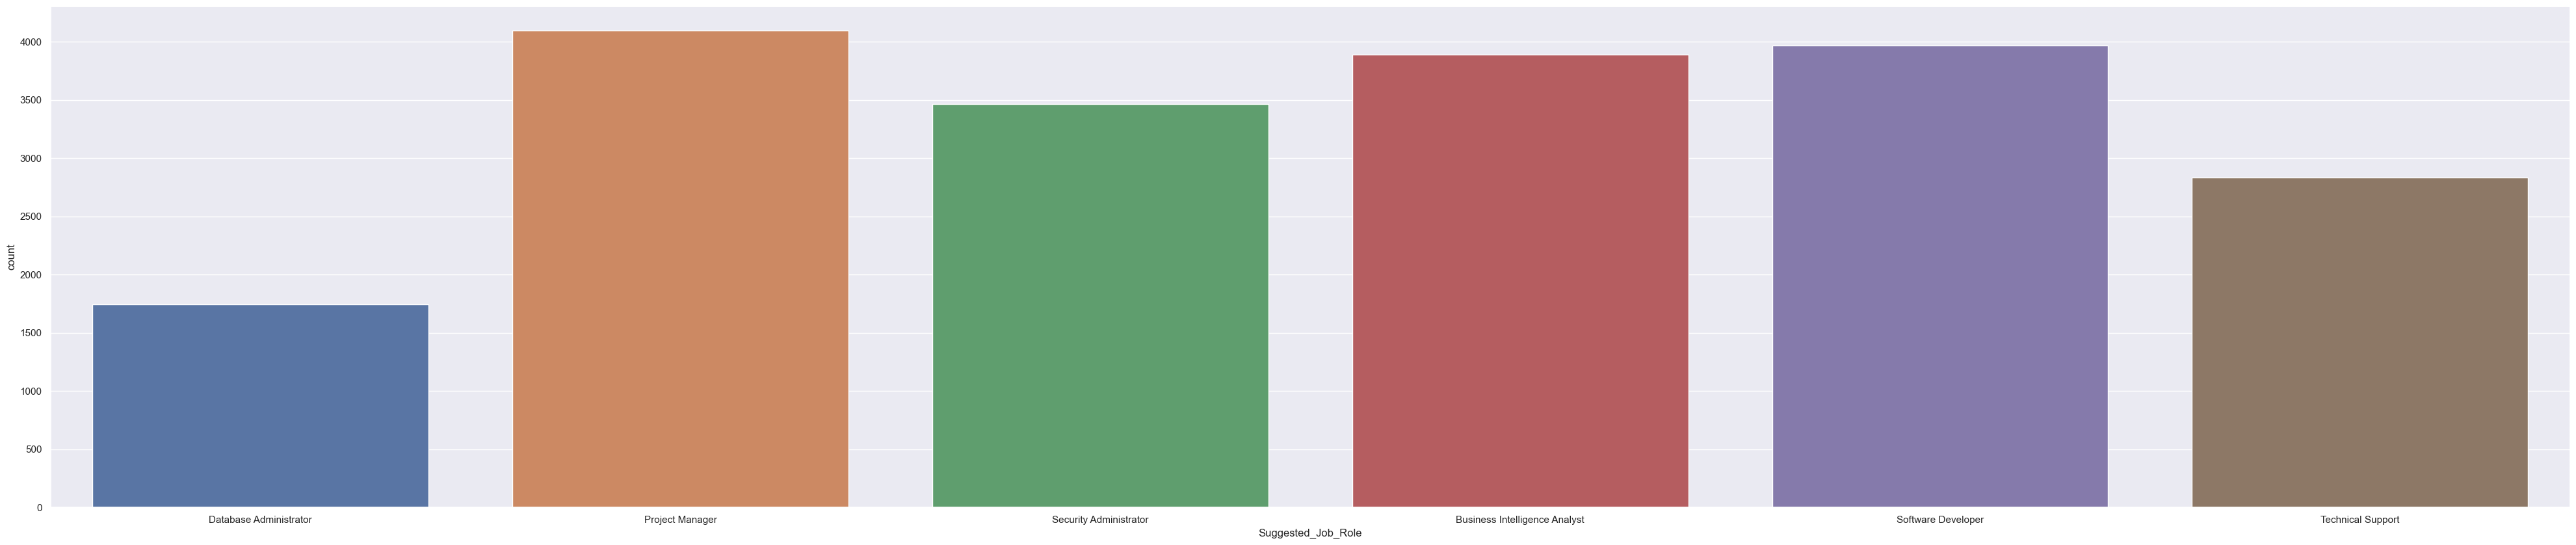

In [36]:
# Checking for data imbalanceness if any
sns.set(rc={'figure.figsize':(50,10)})
sns.countplot(x = df["Suggested_Job_Role"])

Creating a decision tree model just for seeing the importance of features

In [37]:
X = df.drop(columns=["Suggested_Job_Role"],axis=1)
y = df["Suggested_Job_Role"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [38]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
print("confusion matrix=\n",cm)
print("  ")
print("accuracy=",accuracy*100)

confusion matrix=
 [[220  97 244 217 225 161]
 [ 98  47  97 109 102  75]
 [241 116 245 207 232 167]
 [195 100 200 178 205 176]
 [251 111 242 197 241 139]
 [164  65 163 156 183 134]]
  
accuracy= 17.75


In [39]:
plot_importance(clf,X)

#### Feature Engineering

In [40]:
#Introvert no = 0
def categorise_confidence(row,col_avg):
    if row['Public_Speaking_Points'] > col_avg and row['Introvert'] == 0:
        return 'self_confident'
    elif row['Public_Speaking_Points'] > col_avg and row['Introvert'] == 1:
        return 'only_introvert'
    elif row['Public_Speaking_Points'] < col_avg and row['Introvert'] == 0:
        return 'not_self_confident'
    elif row['Public_Speaking_Points'] < col_avg and row['Introvert'] == 1:
        return 'low_speaking_skill'

In [41]:
col_avg = df["Public_Speaking_Points"].mean()
df['Confidence'] = df.apply (lambda row: categorise_confidence(row,col_avg), axis=1)
df2 = pd.get_dummies(df["Confidence"], prefix="dum", drop_first=True)
df = df.join(df2)
df.drop(columns=["Confidence"], axis = 1, inplace=True)

In [42]:
def categorise_security(row):
    if row['dum_information security'] == 1 or  row['dum_database security'] == 1 or  row['dum_security'] == 1:
        return '1'
    else:
        return '0'

In [43]:
df['Security'] = df.apply (lambda row: categorise_security(row), axis=1)

In [44]:
def categorise_coding(row):
    if row['Coding_Skills_Rating'] < 3:
        return 'low_coding_skill'
    elif 3 <= row['Coding_Skills_Rating'] < 6:
        return 'medium_coding_skill'
    else:
        return 'high_coding'

In [45]:
df['Coding_Skills'] = df.apply (lambda row: categorise_coding(row), axis=1)
df2 = pd.get_dummies(df["Coding_Skills"], prefix="dum", drop_first=True)
df = df.join(df2)
df.drop(columns=["Coding_Skills"], axis = 1, inplace=True)

In [46]:
df["Hackathons_Coding"] = df["Coding_Skills_Rating"]*df["Hackathons"]

In [47]:
df["LogicalQuotient_Memory"] = df["Logical_Quotient_Rating"]*df["Memory_Capability_Score"]

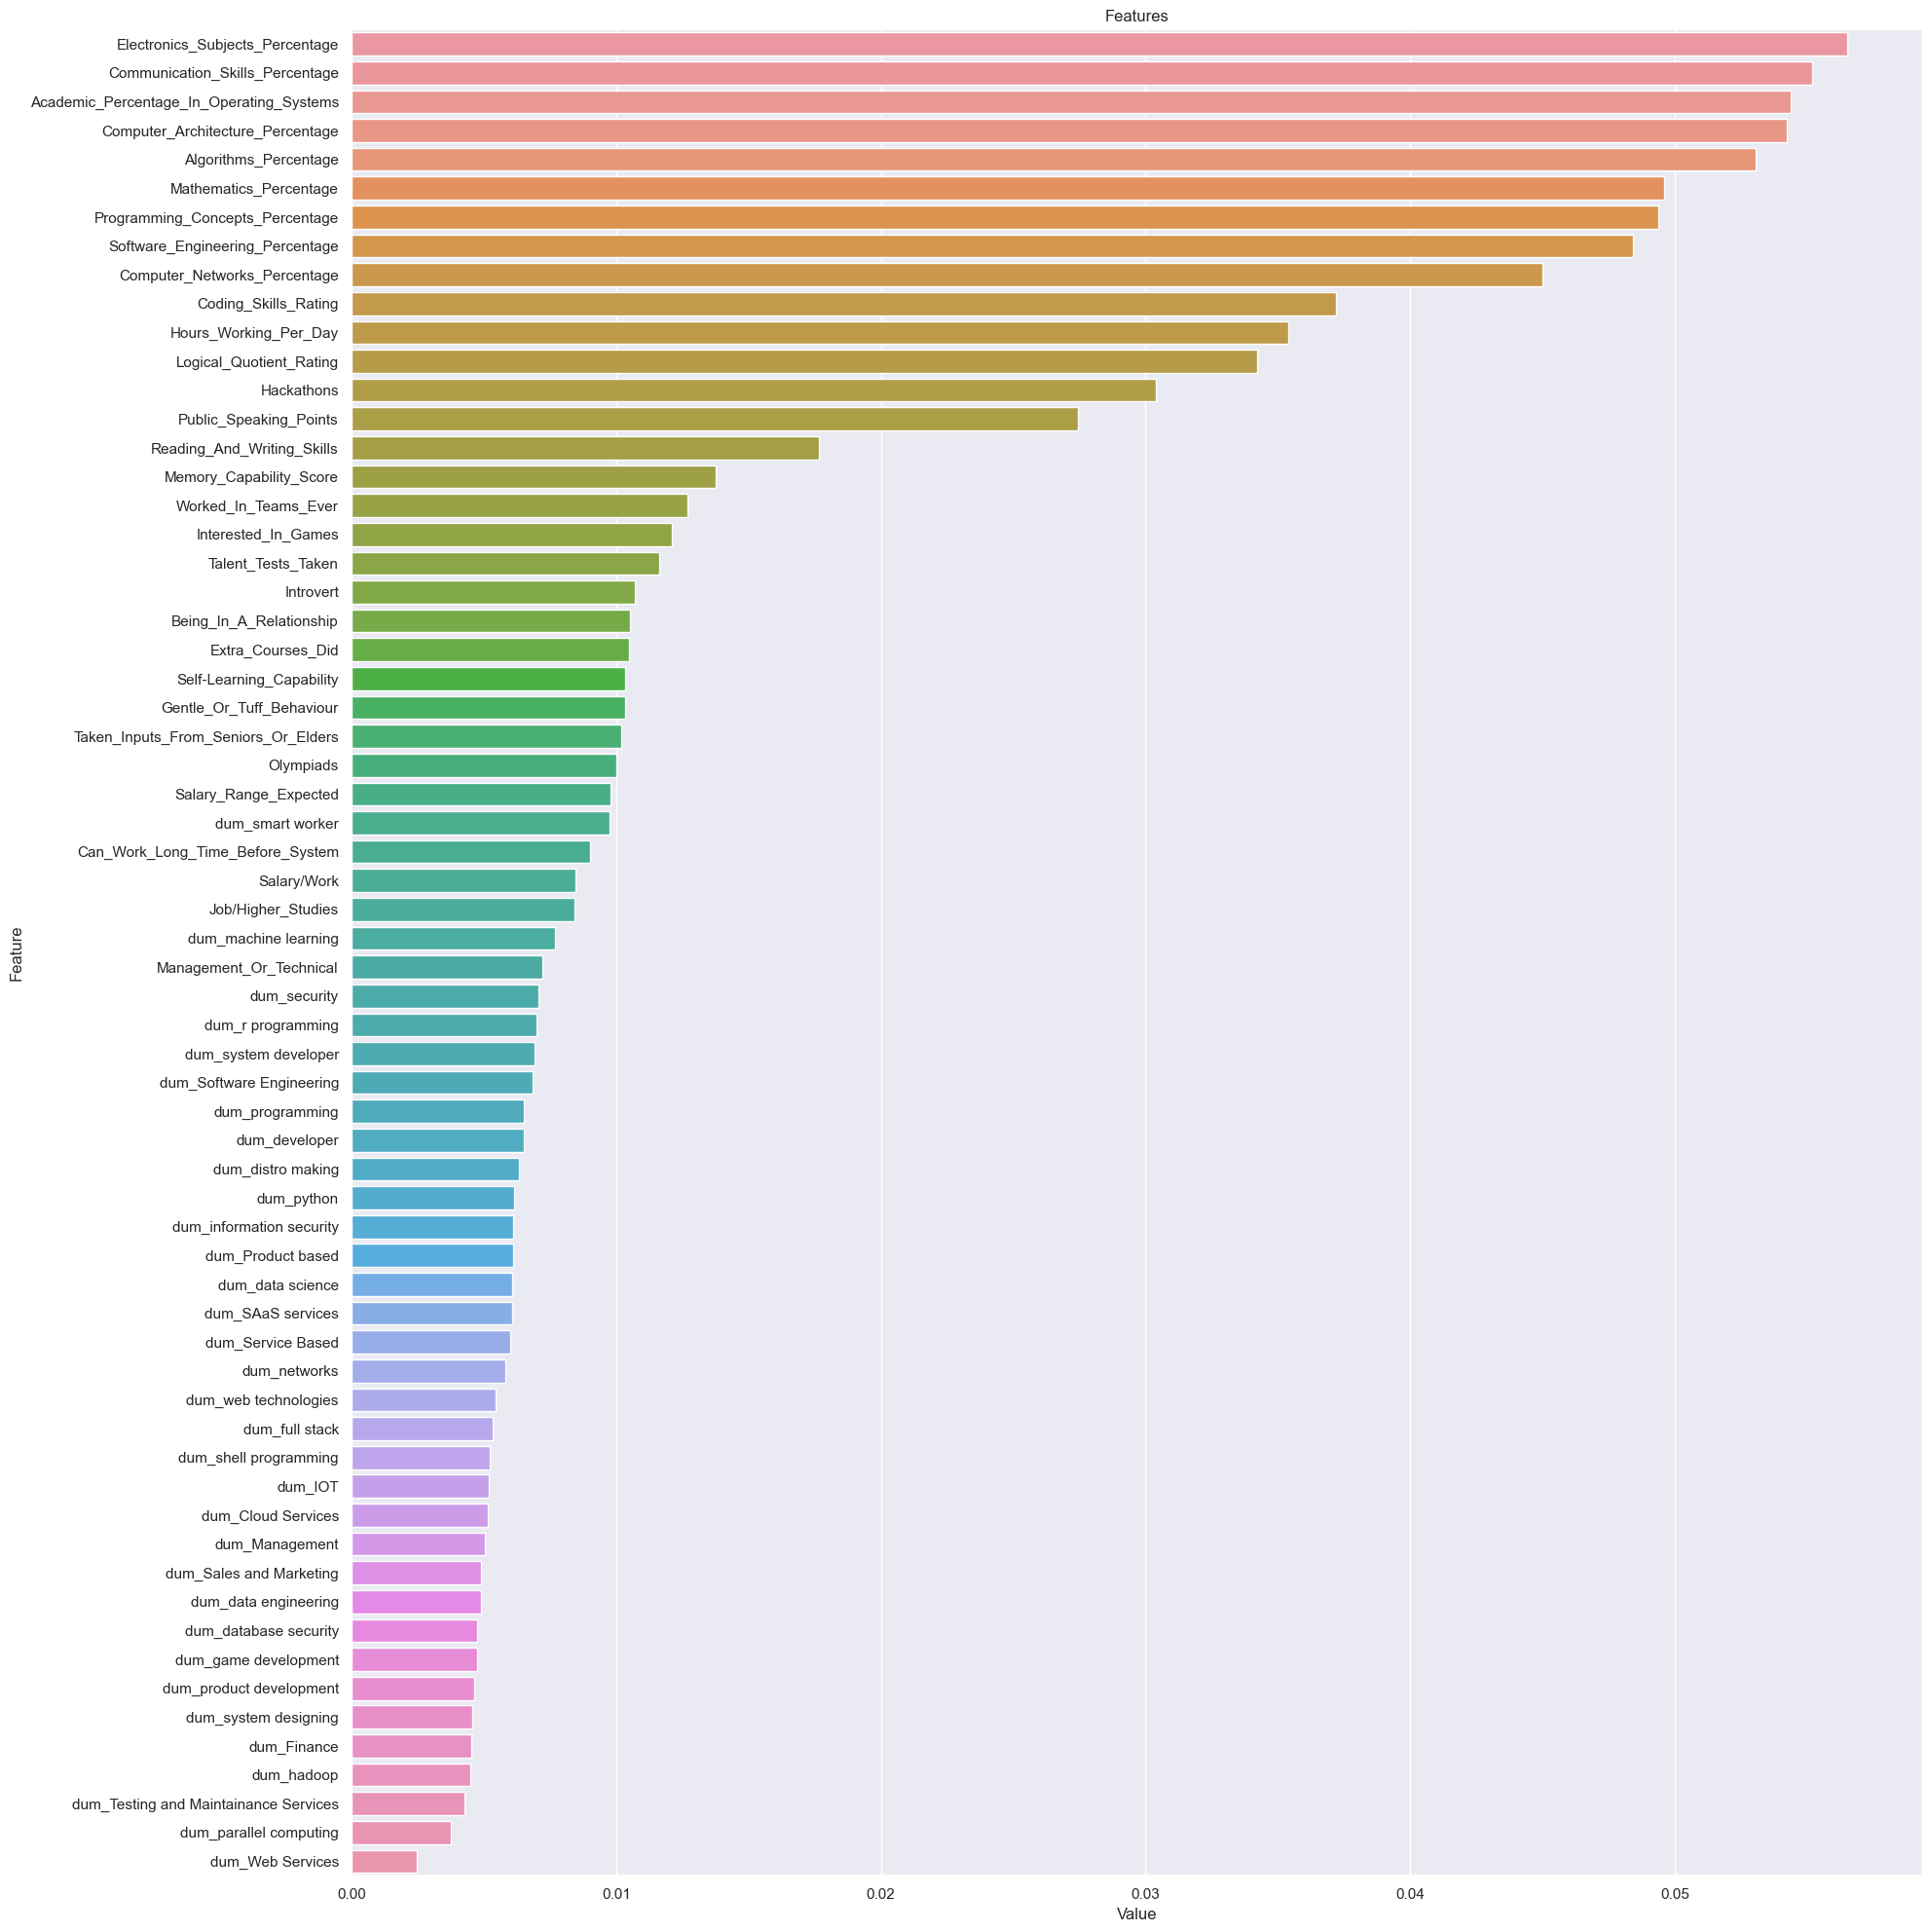

In [48]:
plot_importance(clf,X)

## Creating Models

In [49]:
X = df.drop(columns=["Suggested_Job_Role"],axis=1)
y = df["Suggested_Job_Role"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [50]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
print("confusion matrix=\n",cm)
print("  ")
print("accuracy=",accuracy*100)

confusion matrix=
 [[224 100 231 221 239 149]
 [109  54  98  98  97  72]
 [248 102 258 203 219 178]
 [216 108 212 163 194 161]
 [244 104 233 218 244 138]
 [187  75 161 147 165 130]]
  
accuracy= 17.883333333333333


In [51]:
model = LogisticRegression()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
print("confusion matrix=\n",cm)
print("  ")
print("accuracy=",accuracy*100)

confusion matrix=
 [[308   0 474  98 269  15]
 [147   0 188  46 142   5]
 [283   0 505  92 311  17]
 [247   0 416 107 272  12]
 [289   0 456 110 311  15]
 [230   0 344  63 218  10]]
  
accuracy= 20.683333333333334
